In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/mid_term_nlp/imdb'

/content/drive/MyDrive/mid_term_nlp/imdb


In [ ]:
import numpy as np
import pandas as pd
from utils import *
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import accuracy_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!python -m spacy download en_core_web_md
# Load the spaCy NLP model
nlp = spacy.load("en_core_web_md")

2024-01-29 05:12:34.358447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 05:12:34.358499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 05:12:34.359773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 05:12:35.976339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 4.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
df = pd.read_csv('imdb.csv')
df = df[['Review','Sentiment']].dropna()

In [ ]:
df = shuffle(df)
df = df[:10000]

In [ ]:
df.head()

,Review,Sentiment
33979,"I do love B- horror films. I however, am gener...",1
8919,"Our Song is a marvelous example of passionate,...",1
725,"This is an excellent, heartbreaking movie. It ...",1
21574,"Attack Force has a horrendous title, and can a...",0
21197,Despite the rave reviews this flick has garner...,0


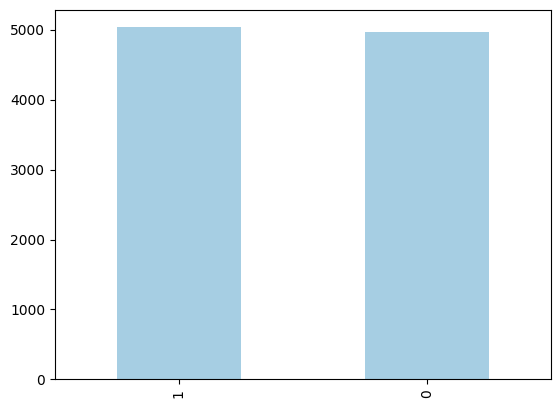

In [ ]:
axplot=df.Sentiment.value_counts().plot(kind='bar', colormap='Paired')
plt.show()

In [ ]:
df['Review'] = df['Review'].apply(clean_html)
df['Review'] = df['Review'].apply(convert_lower)
df['Review'] = df['Review'].apply(remove_special)
df['Review'] = df['Review'].apply(remove_stopwords)
df['Review'] = df['Review'].apply(stem_words)
df['Review'] = df['Review'].apply(join_back)

In [ ]:
print('df shape:', df.shape)
df.head()

df shape: (10000, 2)


,Review,Sentiment
33979,love b horror film howev gener huge fan stupid...,1
8919,song marvel exampl passion movi make aesthet b...,1
725,excel heartbreak movi far best seen depict cur...,1
21574,attack forc horrend titl almost certainli judg...,0
21197,despit rave review flick garner new zealand hy...,0


In [ ]:
X = []
y = []
# Perform Tokenization
for idx, rw in df.iterrows():
 comments = rw["Review"]
 rating = rw["Sentiment"]
 y.append(rating)
 mtoks = [token.text for token in nlp(comments)]
 X.append(mtoks)

In [ ]:
# Create ktoken and perform tokenization
ktoken = Tokenizer(lower=True)
ktoken.fit_on_texts(X)
# Create utterance sequences object
X = ktoken.texts_to_sequences(X)

In [ ]:
a = 0
for i in range(len(X)):
  if a < len(X[i]):
    a = len(X[i])

In [ ]:
a

1096

In [ ]:
# Set the max length to 50
MLEN = 200
# Create pad utterance sequence object
X = pad_sequences(X, MLEN, padding="post")

In [ ]:
# Convert the ps_utterance into numpy arrays
X = np.array(X)
# Create the category list (catlist)
y = np.array(y)

In [ ]:
y = y.reshape(y.shape[0] , 1)

In [ ]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (10000, 200)
y shape: (10000, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

# LSTM Model

In [ ]:
input = Input(shape = (X_train[0].shape))
embedding = Embedding(input_dim = len(ktoken.word_index)+1, output_dim = 300)(input)
x = Conv1D(256, 3, padding = 'same', activation = 'relu')(embedding)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, padding = 'same', activation = 'relu')(x)
x = LSTM(64)(x)
output = Dense(1, activation='sigmoid')(x)

In [ ]:
lstm_model = Model(inputs=[input],outputs=[output], name='LSTM_Model')
lstm_model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_16 (Embedding)    (None, 200, 300)          10858200  
                                                                 
 conv1d_51 (Conv1D)          (None, 200, 256)          230656    
                                                                 
 max_pooling1d_29 (MaxPooli  (None, 100, 256)          0         
 ng1D)                                                           
                                                                 
 conv1d_52 (Conv1D)          (None, 100, 256)          196864    
                                                                 
 lstm_4 (LSTM)               (None, 64)                82176     
                                                        

In [ ]:
lstm_model.compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = lstm_model.fit(x = X_train,
                         y = y_train,
                         batch_size = 32,
                         epochs = 30,
                         validation_split = 0.2)

Epoch 1/30
200/200 [==============================] - 26s 116ms/step - loss: 0.6916 - accuracy: 0.5064 - val_loss: 0.6863 - val_accuracy: 0.5506
Epoch 2/30
200/200 [==============================] - 15s 75ms/step - loss: 0.6054 - accuracy: 0.6661 - val_loss: 0.5782 - val_accuracy: 0.6850
Epoch 3/30
200/200 [==============================] - 13s 64ms/step - loss: 0.4434 - accuracy: 0.8075 - val_loss: 0.5473 - val_accuracy: 0.7681
Epoch 4/30
200/200 [==============================] - 10s 49ms/step - loss: 0.2712 - accuracy: 0.9028 - val_loss: 0.4401 - val_accuracy: 0.8200
Epoch 5/30
200/200 [==============================] - 7s 34ms/step - loss: 0.1631 - accuracy: 0.9428 - val_loss: 0.4601 - val_accuracy: 0.8238
Epoch 6/30
200/200 [==============================] - 6s 30ms/step - loss: 0.0960 - accuracy: 0.9708 - val_loss: 0.5012 - val_accuracy: 0.8325
Epoch 7/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0535 - accuracy: 0.9873 - val_loss: 0.5734 - val_accuracy: 0

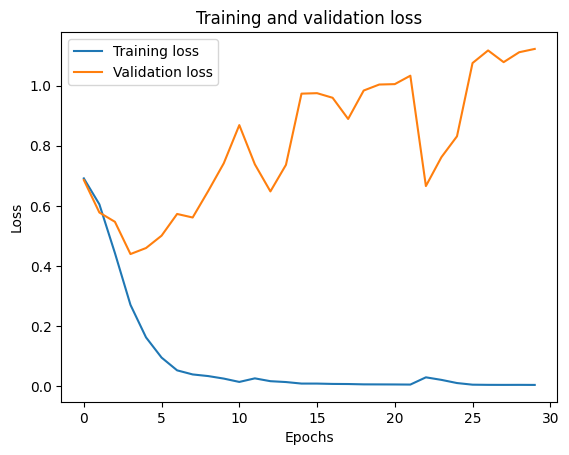

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(0, len(loss))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

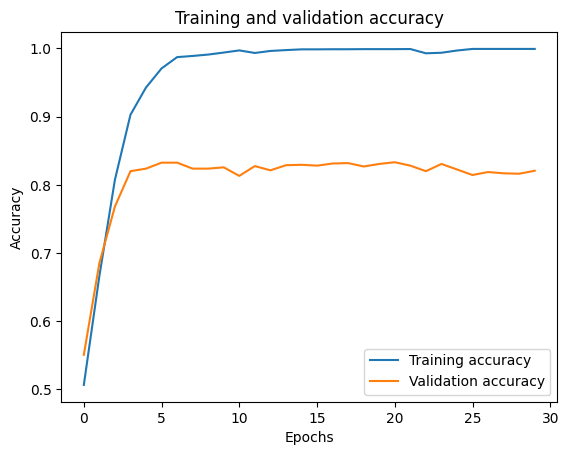

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(0, len(accuracy))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred1 = lstm_model.predict(X_test)

63/63 [==============================] - 1s 10ms/step


In [ ]:
y_pred1[0]

array([0.00059294], dtype=float32)

In [ ]:
for index, y_pred in enumerate(y_pred1):
  if y_pred < 0.5:
    y_pred1[index] = 0
  else:
    y_pred1[index] = 1

In [ ]:
accuracy = accuracy_score(y_test, y_pred1)
print(f"LSTM Accuracy:{accuracy * 100:.3f}%")
recall = recall_score(y_test, y_pred1, average='macro')
print(f"LSTM Recall:{recall * 100:.3f}%")
f1 = f1_score(y_test, y_pred1, average='macro')
print(f"LSTM F1:{f1 * 100:.3f}%")

LSTM Accuracy:84.100%
LSTM Recall:84.129%
LSTM F1:84.095%


In [ ]:
label = ['Positive', 'Negative']

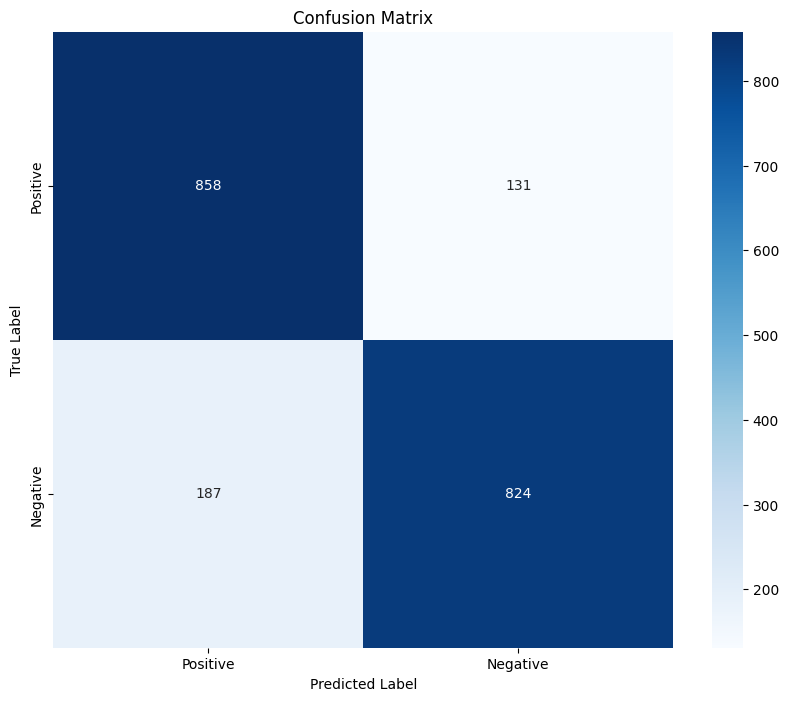

In [ ]:
cm = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# CNN

In [ ]:
input = Input(shape = (X_train[0].shape))
embedding = Embedding(input_dim = len(ktoken.word_index)+1, output_dim = 300)(input)
x = Conv1D(256, 3, padding = 'same', activation = 'relu')(embedding)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, padding = 'same', activation = 'relu')(x)
x = Conv1D(128, 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, padding = 'same', activation = 'relu')(x)
x = Conv1D(64, 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation = 'relu')(x)
x = Dense(16, activation = 'relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [ ]:
cnn_model = Model(inputs=[input],outputs=[output], name='CNN_Model')
cnn_model.summary()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_19 (Embedding)    (None, 200, 300)          10900800  
                                                                 
 conv1d_67 (Conv1D)          (None, 200, 256)          230656    
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 100, 256)          0         
 ng1D)                                                           
                                                                 
 conv1d_68 (Conv1D)          (None, 100, 256)          196864    
                                                                 
 conv1d_69 (Conv1D)          (None, 100, 128)          98432     
                                                         

In [ ]:
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = cnn_model.fit(x = X_train,
                         y = y_train,
                         batch_size = 32,
                         epochs = 100,
                         validation_split = 0.2)

Epoch 1/100
200/200 [==============================] - 41s 180ms/step - loss: 0.6932 - accuracy: 0.5080 - val_loss: 0.6902 - val_accuracy: 0.4819
Epoch 2/100
200/200 [==============================] - 25s 125ms/step - loss: 0.4397 - accuracy: 0.7997 - val_loss: 0.3530 - val_accuracy: 0.8531
Epoch 3/100
200/200 [==============================] - 17s 86ms/step - loss: 0.1268 - accuracy: 0.9533 - val_loss: 0.4684 - val_accuracy: 0.8413
Epoch 4/100
200/200 [==============================] - 15s 78ms/step - loss: 0.0338 - accuracy: 0.9894 - val_loss: 0.6341 - val_accuracy: 0.8462
Epoch 5/100
200/200 [==============================] - 8s 42ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 1.2560 - val_accuracy: 0.8231
Epoch 6/100
200/200 [==============================] - 10s 51ms/step - loss: 0.0040 - accuracy: 0.9984 - val_loss: 1.6819 - val_accuracy: 0.8238
Epoch 7/100
200/200 [==============================] - 7s 33ms/step - loss: 0.0341 - accuracy: 0.9884 - val_loss: 0.9875 - val_ac

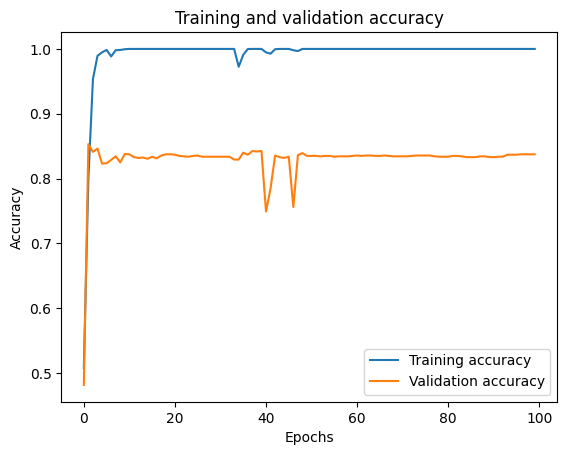

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(0, len(accuracy))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred2 = cnn_model.predict(X_test)

63/63 [==============================] - 0s 5ms/step


In [ ]:
y_test.shape

(2000, 1)

In [ ]:
y_pred2.shape

(2000, 1)

In [ ]:
for index, y_pred in enumerate(y_pred2):
  if y_pred < 0.5:
    y_pred2[index] = 0
  else:
    y_pred2[index] = 1

In [ ]:
accuracy = accuracy_score(y_test, y_pred2)
print(f"CNN Accuracy:{accuracy * 100:.3f}%")
recall = recall_score(y_test, y_pred2, average='macro')
print(f"CNN Recall:{recall * 100:.3f}%")
f1 = f1_score(y_test, y_pred2, average='macro')
print(f"CNN F1:{f1 * 100:.3f}%")

CNN Accuracy:81.700%
CNN Recall:81.644%
CNN F1:81.661%


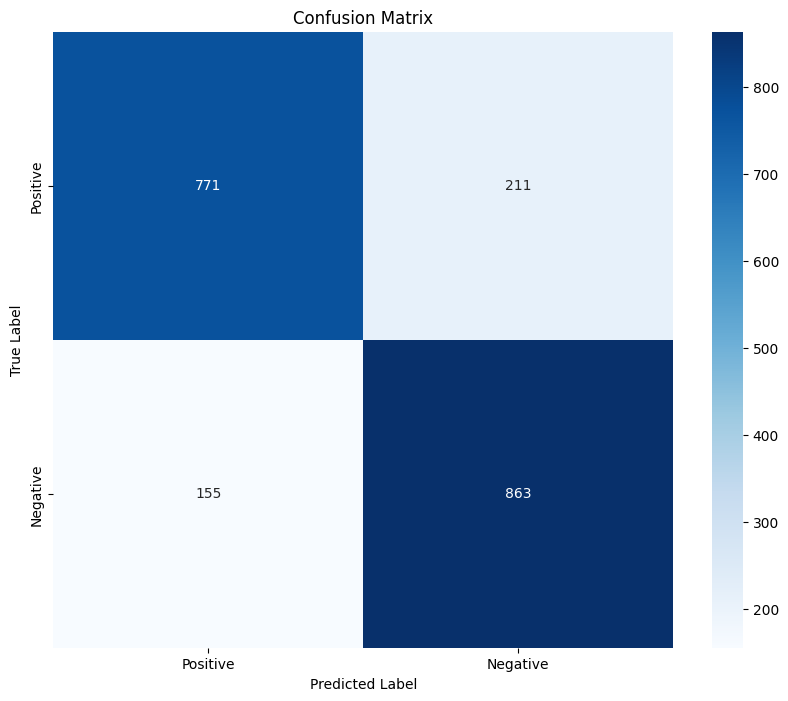

In [ ]:
cm = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()